In [80]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_rows', 9999)

# データ整形
2013年9月26日の1:100の株式分割を調整したデータを用いる

In [10]:
df = pd.read_csv("7203_2003.csv", encoding='cp932', header=1)
for i in range(16):
    year = i+2004
    temp = pd.read_csv(f"7203_{year}.csv", encoding='cp932', header=1)
    df = pd.concat((df,temp),axis=0)
df = df.reset_index(drop=True)

In [12]:
df.tail()

日付    始値    高値    安値    終値      出来高  終値調整値
4137  2019-11-26  7788  7820  7707  7708  4567100   7708
4138  2019-11-27  7706  7728  7685  7690  2744100   7690
4139  2019-11-28  7740  7757  7688  7724  3226900   7724
4140  2019-11-29  7740  7740  7638  7638  3762600   7638
4141  2019-12-02  7701  7761  7682  7738  3913300   7738

マーケット株価としてTOPIXを採用する。

In [15]:
topix = pd.read_csv("topix.csv").rename(columns={'終値': 'TOPIX終値', '日付': 'TOPIX日付'})

In [16]:
topix.head()

TOPIX日付       始値       高値       安値  TOPIX終値
0  2019/12/02  1705.99  1717.35  1705.23  1714.49
1  2019/11/29  1712.21  1712.83  1698.01  1699.36
2  2019/11/28  1712.02   1713.4  1703.54  1708.06
3  2019/11/27  1710.43   1714.6  1709.21  1710.98
4  2019/11/26  1712.61  1719.57  1705.04  1705.71

In [17]:
for i in range(len(topix)):
    if (i%22 == 20) or (i%22 == 21):
        topix.drop(i, inplace=True)
topix = topix[::-1].reset_index(drop=True)
topix_copy = topix.copy()
topix.drop([3380,3382,3647,4090], axis=0, inplace=True)
topix = topix.reset_index(drop=True)

無リスク資産として、日本国債（10年）を採用する

In [18]:
bond = pd.read_csv("bond.csv")
bond.drop([3380,3382,3647,4090], axis=0, inplace=True)
bond = bond.reset_index(drop=True)

In [19]:
bond.tail()

国債日付     金利
4137  2019/11/26 -0.092
4138  2019/11/27 -0.106
4139  2019/11/28 -0.086
4140  2019/11/29 -0.075
4141  2019/12/02 -0.046

In [20]:
date = pd.concat((df["日付"].str.replace('-',''),topix["TOPIX日付"].str.replace('/','')),axis=1)
date.fillna(0,inplace=True)
date = date.astype(int)
for i in range(len(date)):
    if date.loc[i,"日付"]!=date.loc[i,"TOPIX日付"]:
        print(i)

In [21]:
date = pd.concat((df["日付"].str.replace('-',''),bond["国債日付"].str.replace('/','')),axis=1)
date.fillna(0,inplace=True)
date = date.astype(int)
for i in range(len(date)):
    if date.loc[i,"日付"]!=date.loc[i,"国債日付"]:
        print(i)

In [24]:
df.shape, topix.shape, bond.shape

((4142, 7), (4142, 5), (4142, 2))

In [25]:
df = pd.concat((df,topix["TOPIX終値"].astype(float)),axis=1)
df = pd.concat((df,bond["金利"].astype(float)),axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4142 entries, 0 to 4141
Data columns (total 9 columns):
日付         4142 non-null object
始値         4142 non-null int64
高値         4142 non-null int64
安値         4142 non-null int64
終値         4142 non-null int64
出来高        4142 non-null int64
終値調整値      4142 non-null int64
TOPIX終値    4142 non-null float64
金利         4142 non-null float64
dtypes: float64(2), int64(6), object(1)
memory usage: 291.3+ KB


In [27]:
df["日足収益率"] = df["終値調整値"].diff()
df["TOPIX日足利益率"] = df["TOPIX終値"].diff()
df["日足収益率"][:-1] = df["日足収益率"][1:]
df["TOPIX日足利益率"][:-1] = df["TOPIX日足利益率"][1:]
df["日足収益率"] = df["日足収益率"]/df["終値調整値"]
df["TOPIX日足利益率"] = df["TOPIX日足利益率"]/df["TOPIX終値"]
df["日足収益率"][1:] = df["日足収益率"][:-1]
df["TOPIX日足利益率"][1:] = df["TOPIX日足利益率"][:-1]
df["日足収益率"][0:1]=np.nan
df["TOPIX日足利益率"][0:1]=np.nan

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packa

In [28]:
df["週足収益率"] = df["終値調整値"].diff(7)
df["TOPIX週足利益率"] = df["TOPIX終値"].diff(7)
df["週足収益率"][:-7] = df["週足収益率"][7:]
df["TOPIX週足利益率"][:-7] = df["TOPIX週足利益率"][7:]
df["週足収益率"] = df["週足収益率"]/df["終値調整値"]
df["TOPIX週足利益率"] = df["TOPIX週足利益率"]/df["TOPIX終値"]
df["週足収益率"][7:] = df["週足収益率"][:-7]
df["TOPIX週足利益率"][7:] = df["TOPIX週足利益率"][:-7]
df["週足収益率"][0:7]=np.nan
df["TOPIX週足利益率"][0:7]=np.nan

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packa

In [29]:
df["月間収益率"] = df["終値調整値"].diff(30)
df["TOPIX月間利益率"] = df["TOPIX終値"].diff(30)
df["月間収益率"][:-30] = df["月間収益率"][30:]
df["TOPIX月間利益率"][:-30] = df["TOPIX月間利益率"][30:]
df["月間収益率"] = df["月間収益率"]/df["終値調整値"]
df["TOPIX月間利益率"] = df["TOPIX月間利益率"]/df["TOPIX終値"]
df["月間収益率"][30:] = df["月間収益率"][:-30]
df["TOPIX月間利益率"][30:] = df["TOPIX月間利益率"][:-30]
df["月間収益率"][0:30]=np.nan
df["TOPIX月間利益率"][0:30]=np.nan

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packa

In [30]:
df.tail()

日付    始値    高値    安値    終値      出来高  終値調整値  TOPIX終値     金利  \
4134  2019-11-21  7696  7742  7590  7716  5193600   7716  1689.38 -0.107   
4135  2019-11-22  7728  7783  7723  7753  3514400   7753  1691.34 -0.077   
4136  2019-11-25  7794  7795  7715  7729  2625600   7729  1702.96 -0.081   
4137  2019-11-26  7788  7820  7707  7708  4567100   7708  1705.71 -0.092   
4138  2019-11-27  7706  7728  7685  7690  2744100   7690  1710.98 -0.106   
4139  2019-11-28  7740  7757  7688  7724  3226900   7724  1708.06 -0.086   
4140  2019-11-29  7740  7740  7638  7638  3762600   7638  1699.36 -0.075   
4141  2019-12-02  7701  7761  7682  7738  3913300   7738  1714.49 -0.046   

         日足収益率  TOPIX日足利益率     週足収益率  TOPIX週足利益率     月間収益率  TOPIX月間利益率  
4134  0.003642   -0.001023 -0.022796   -0.011868  0.104495    0.074157  
4135  0.004795    0.001160 -0.017239   -0.005287  0.093975    0.066083  
4136 -0.003096    0.006870 -0.008467    0.011019  0.084772    0.076664  
4137 -0.002717    0.001615 -0.015078    0.005328  0.084412    0.078594  
4138 -0.002335    0.003090 -0.018632    0.006033  0.057917    0.072533  
4139  0.004421   -0.001707 -0.003869    0.006678  0.045904    0.054228  
4140 -0.011134   -0.005093 -0.006504    0.004878  0.024547    0.041587  
4141  0.013092    0.008903  0.002851    0.014863  0.048083    0.055616

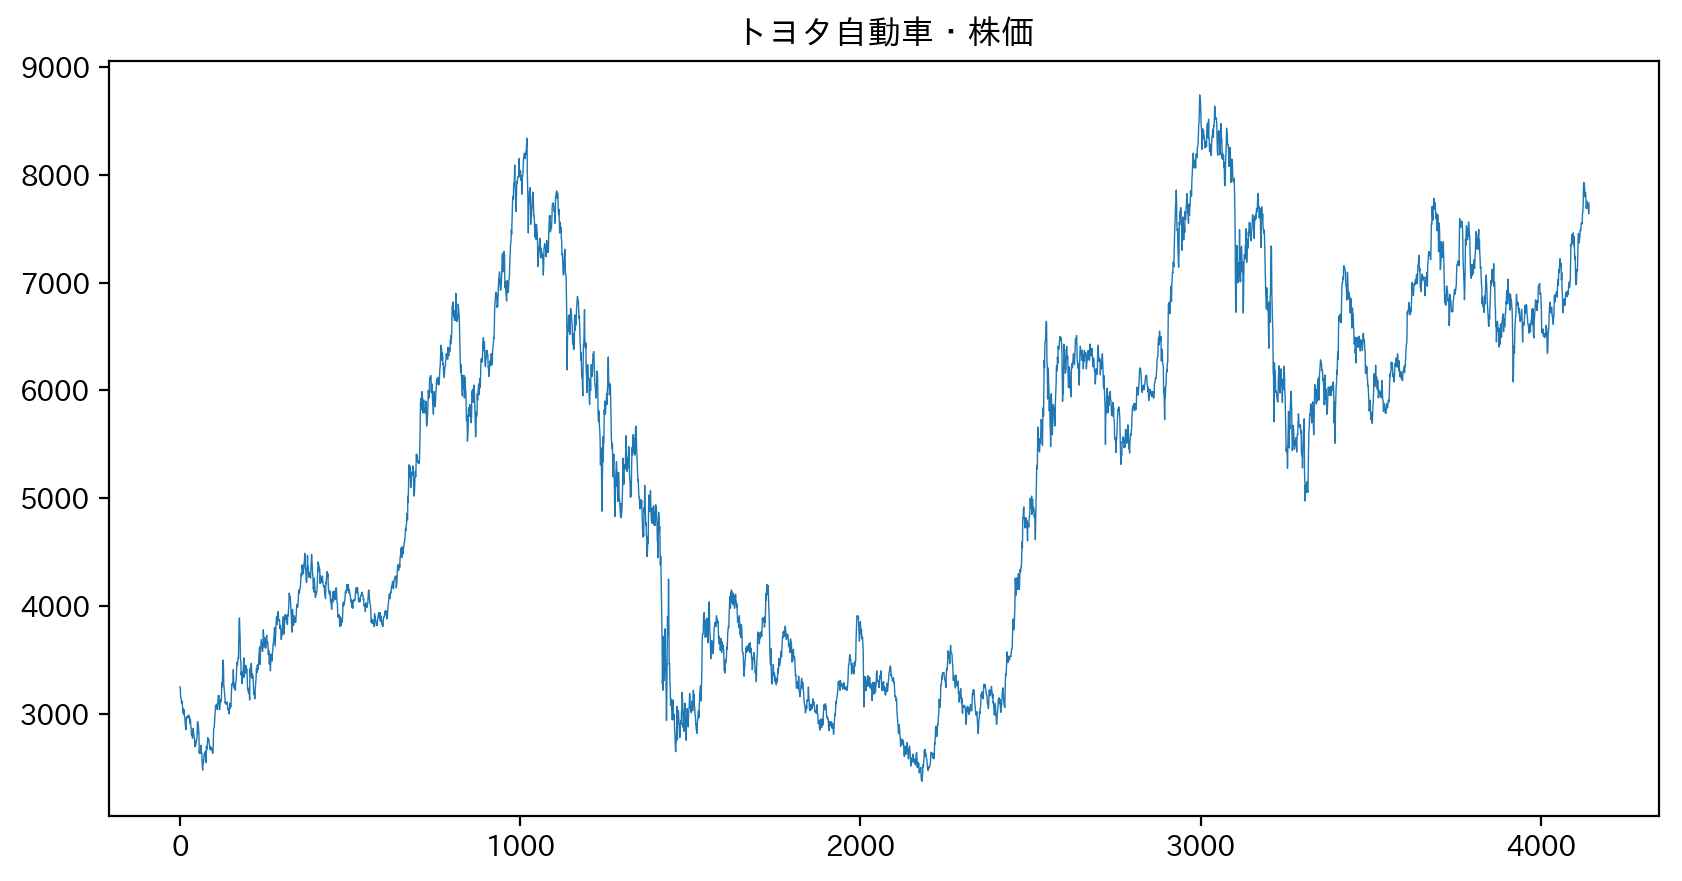

In [32]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"トヨタ自動車・株価")
plt.plot(df["終値調整値"], linewidth=0.5)

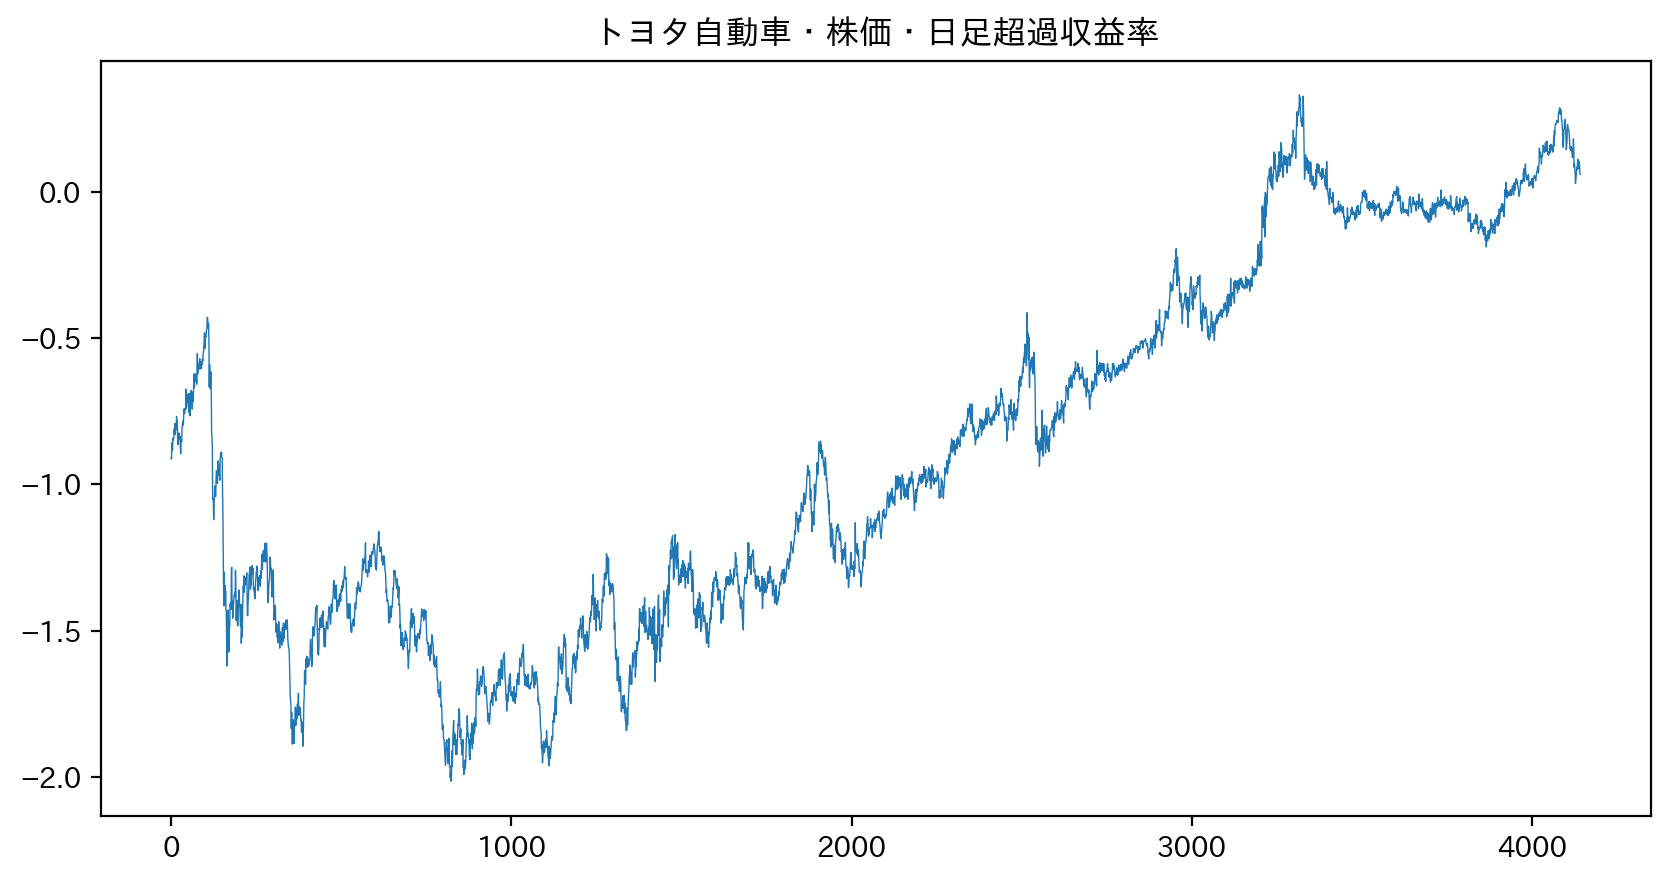

In [33]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"トヨタ自動車・株価・日足超過収益率")
plt.plot(df["日足収益率"][1:]-df["金利"][1:], linewidth=0.5)

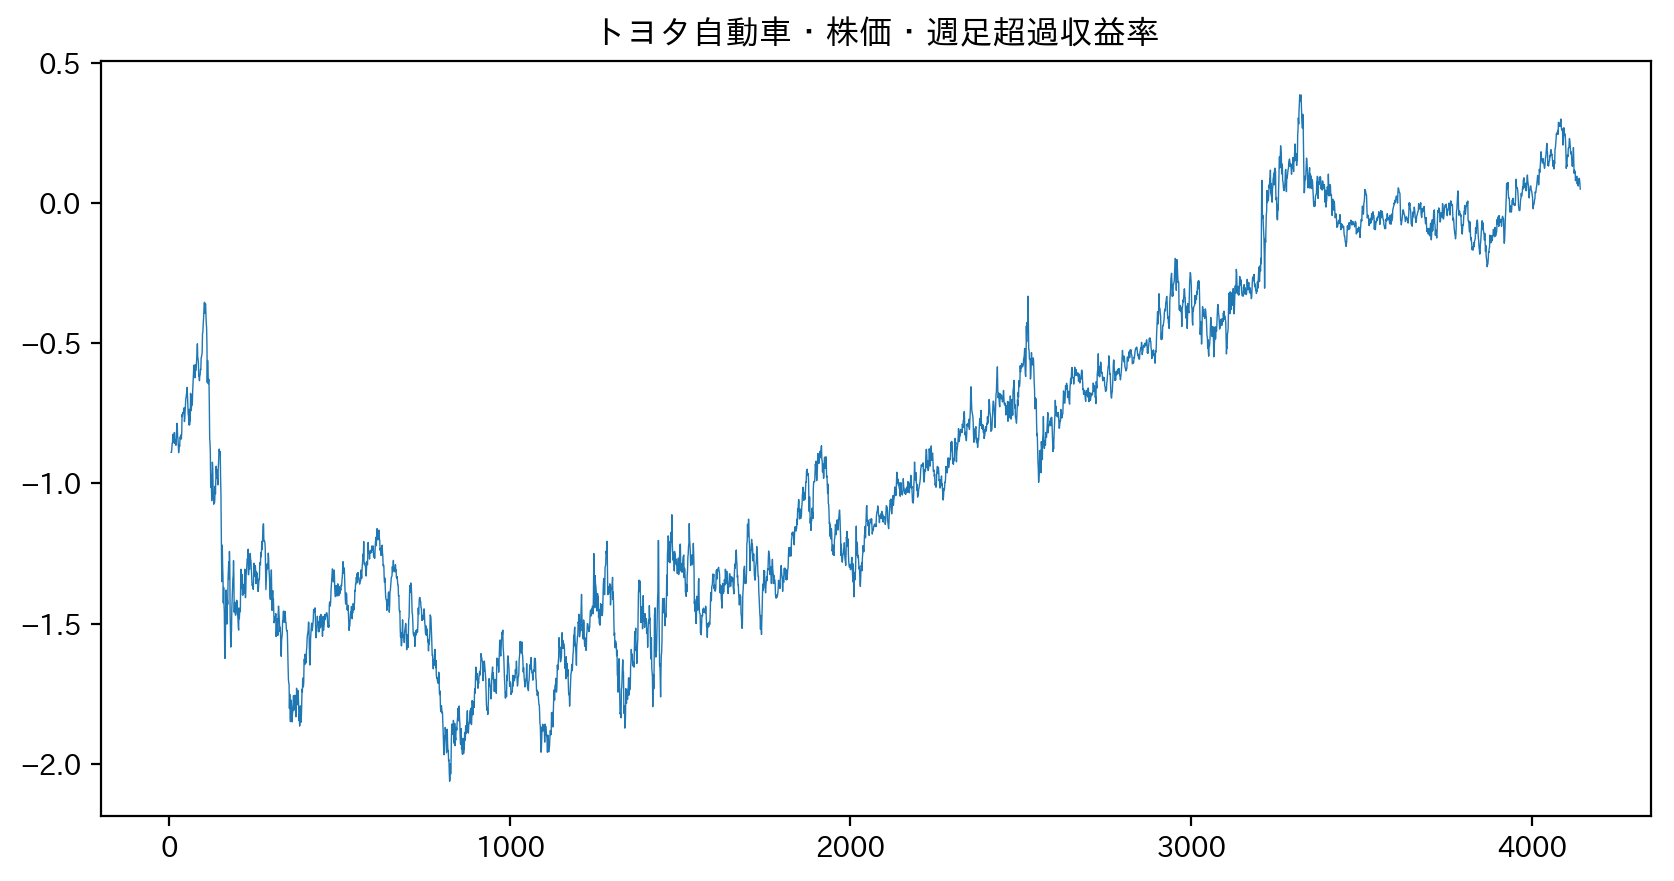

In [34]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"トヨタ自動車・株価・週足超過収益率")
plt.plot(df["週足収益率"][7:]-df["金利"][7:], linewidth=0.5)

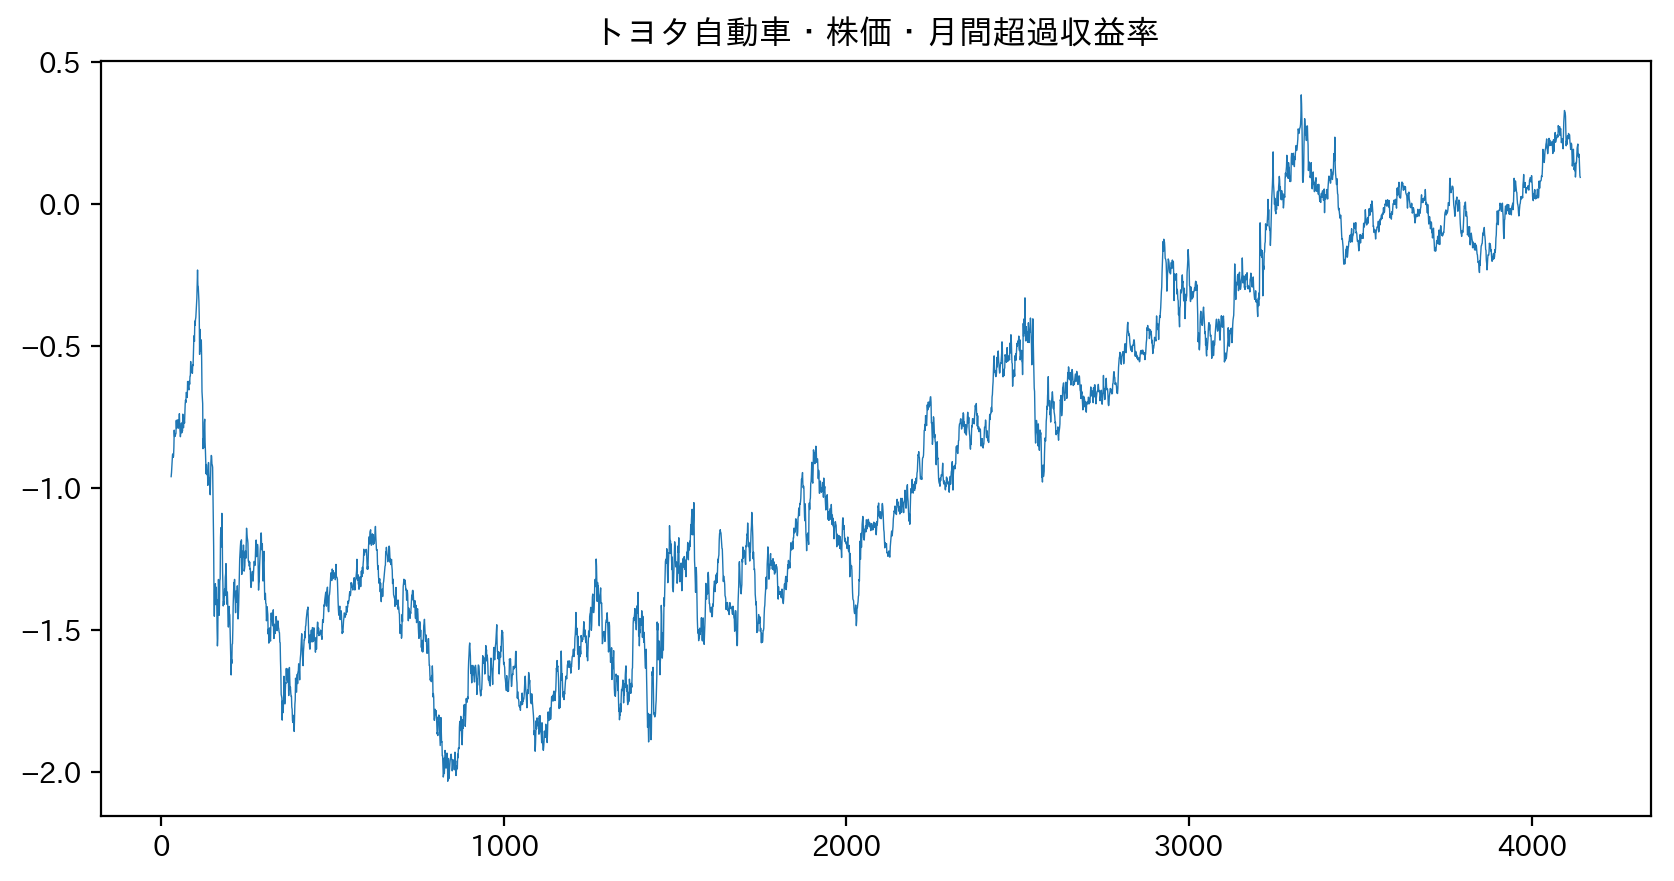

In [35]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"トヨタ自動車・株価・月間超過収益率")
plt.plot(df["月間収益率"][30:]-df["金利"][30:], linewidth=0.5)

In [41]:
x = df["月間収益率"][30:]-df["金利"][30:]
length = len(x)

In [42]:
x.shape

(4112,)

In [43]:
x.mean()

-0.8743035933088424

In [44]:
x.std()

0.6319247506951736

# MCMC

In [45]:
epsilon = 0.01
#　update width
trial = 25000
# trial: how many times do mcmc

In [46]:
theta = [-1.4,-0.25,0.05,0.125,3,3,0,0]
theta[6] = np.exp(theta[4])/(1+np.exp(theta[4]))
theta[7] = np.exp(theta[5])/(1+np.exp(theta[5]))
# theta[0] = mu1
# theta[1] = mu2
# theta[2] = sigma1
# theta[3] = sigma2
# theta[4] = p0
# theta[5] = q0
# theta[6] = p
# theta[7] = q

num_val = len(theta)

対数尤度を計算する関数

In [47]:
def cal_logL(x, theta):
    likelihood1 = stats.norm.pdf(x=x, loc=theta[0], scale=np.sqrt(theta[2]))
    likelihood2 = stats.norm.pdf(x=x, loc=theta[1], scale=np.sqrt(theta[3]))
    
    prior1=(1-theta[7])/(2-theta[6]-theta[7])
    prior2=(1-theta[6])/(2-theta[6]-theta[7])
    
    logL = 0
    for i in range(length):
        temp1 = likelihood1[i]*prior1
        temp2 = likelihood2[i]*prior2

        posterior1 = temp1/(temp1+temp2)
        posterior2 = temp2/(temp1+temp2)

        logL += np.log(temp1+temp2)
        
        prior1 = theta[6]*posterior1 + (1-theta[7])*posterior2
        prior2 = (1-theta[6])*posterior1 + theta[7]*posterior2
        
    return logL

各レジームである確率の配列を返す関数

In [48]:
def prob_regime(x, theta):
    likelihood1 = stats.norm.pdf(x=x, loc=theta[0], scale=np.sqrt(theta[2]))
    likelihood2 = stats.norm.pdf(x=x, loc=theta[1], scale=np.sqrt(theta[3]))
    
    prior1=(1-theta[7])/(2-theta[6]-theta[7])
    prior2=(1-theta[6])/(2-theta[6]-theta[7])
    
    prob_list1 = []
    prob_list2 = []
    for i in range(length):
        temp1 = likelihood1[i]*prior1
        temp2 = likelihood2[i]*prior2

        prob_list1.append(temp1/(temp1+temp2))
        prob_list2.append(temp2/(temp1+temp2))
        
        posterior1 = temp1/(temp1+temp2)
        posterior2 = temp2/(temp1+temp2)
        
        prior1 = theta[6]*posterior1 + (1-theta[7])*posterior2
        prior2 = (1-theta[6])*posterior1 + theta[7]*posterior2
    
    return prob_list1, prob_list2

$\theta$を更新する関数。  
レジーム1よりレジーム2のボラティリティが大きいことを条件としている。

In [49]:
def create_next_theta(theta, epsilon):
    new_theta = theta.copy()
    new_theta[0:6] += (2*np.random.rand(6)-1)*epsilon
    new_theta[2:4] = np.exp(np.log(theta[2:4]) + (2*np.random.rand(2)-1)*epsilon)
    
    if new_theta[2]>new_theta[3]:
        new_theta[3] = theta[3]
        new_theta[2] = theta[2]

    new_theta[6] = np.exp(new_theta[4])/(1+np.exp(new_theta[4]))
    new_theta[7] = np.exp(new_theta[5])/(1+np.exp(new_theta[5]))
    
    return list(new_theta)

MCMCを実行する関数

In [50]:
def mcmc(x, theta, trial):
    # x: time_series
    # theta: parameter
    # trial: how many times do mcmc
    
    theta_list = []
    logL_list = []
    theta_list.append(theta)
    
    for i in tqdm(range(trial)):
        next_theta = create_next_theta(theta, epsilon)
        
        logL = cal_logL(x, theta)
        next_logL = cal_logL(x, next_theta)
        
        ratio = np.exp(next_logL-logL)
        logL_list.append(logL)

        if ratio > 1:
            theta = next_theta

        elif ratio > np.random.rand():
            theta = next_theta

        theta_list.append(theta)
        
        #if np.abs(np.log(ratio)) < 10**(-8):
            #return theta_list
        
        #if (i <120) & (i%4==0):
        if (False):
            prob1, prob2 = prob_regime(x, theta)
            regime = np.array(prob2)>=0.5
            regime = regime.astype(int)

            fig = plt.figure(figsize=(10,5),dpi=200)
            ax1 = fig.add_subplot(111)
            ln1=ax1.plot(range(length), x, linewidth=0.7, color="black", label="data")

            ax2 = ax1.twinx()
            ln2=ax2.bar(range(length), 1-np.array(regime), width=1.0, color="blue", alpha=0.4, label=r"$P(I(t) = 1)$")
            ln2=ax2.bar(range(length), regime, width=1.0, color="red", alpha=0.4, label=r"$P(I(t) = 2)$")

            h1, l1 = ax1.get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor="gray", fancybox=False)

            ax1.set_xlabel('t')
            ax1.set_ylabel(r'data')
            ax2.set_ylabel(r'$P(I(t) = 2)$')
            ax1.set_title(f"Estimated Regime, epsilon={epsilon}, trial={i}/{trial}")
            plt.savefig(f'regime_estimating_{i}.png')
            
        if i%100==0:
            print(logL)
    
    return theta_list, logL_list

### 実行

In [51]:
theta_list, logL_list = mcmc(x, theta, trial)

-986.4132116806886
-935.1494689121349
-917.4428653814649
-904.2658133514806
-894.8361099423137
-880.0599645643164
-871.7547839616132
-859.1334221479216
-857.0815436704625
-847.5406851752196
-847.3143393493689
-840.1626341225559
-837.1912604025778
-833.1251855373088
-837.8939301867556
-830.6264278273794
-824.1486757382726
-825.8016597604975
-820.1088195961177
-816.720832490413
-819.6692281416194
-814.75158142759
-815.1071166421056
-808.7565594187381
-809.5651737313357
-802.2360616971213
-803.7355677800339
-803.8181339460255
-800.6534803252698
-800.7337910982683
-795.6428191895249
-794.5699034398976
-792.1733195369717
-790.0682505581376
-789.7410090356216
-789.5451092054165
-787.2666080016428
-785.0283538304511
-785.4557490852109
-786.6267015025492
-783.4486215229367
-786.5747418644987
-778.2312727897908
-779.3859711587447
-778.461101679638
-779.463702021027
-779.9837471215086
-780.2860715416762
-778.9299064501763
-776.4992010642541
-774.9020714595299
-774.8465029214918
-773.557034345851

In [52]:
theta_list = np.array(theta_list)

In [53]:
prob1, prob2 = prob_regime(x, theta_list[-1])

In [86]:
prob = pd.DataFrame(np.round(prob2,3))
prob.index = prob.index + 30
pd.concat((df,prob),axis=1)

日付    始値    高値    安値    終値       出来高  終値調整値  TOPIX終値     金利  \
0     2003-01-06  3250  3270  3240  3250   3531400   3250   860.07  0.911   
1     2003-01-07  3290  3300  3220  3240   5907800   3240   853.93  0.906   
2     2003-01-08  3230  3230  3160  3170   3242100   3170   839.55  0.892   
3     2003-01-09  3150  3180  3130  3150   3947300   3150   839.33  0.852   
4     2003-01-10  3160  3170  3100  3140   4010200   3140   837.70  0.870   
5     2003-01-14  3130  3140  3080  3100   4175800   3100   845.90  0.872   
6     2003-01-15  3120  3120  3090  3120   4586000   3120   855.66  0.849   
7     2003-01-16  3100  3110  3070  3090   4417500   3090   856.30  0.840   
8     2003-01-17  3050  3090  3050  3060   4945200   3060   859.25  0.834   
9     2003-01-20  3030  3040  2990  3010   5897700   3010   853.90  0.825   
10    2003-01-21  3010  3070  3010  3050   6200100   3050   863.64  0.825   
11    2003-01-22  3020  3030  2990  3000   6093300   3000   854.06  0.811   
12    2003-01-23  3010  3040  2995  3040   5011800   3040   865.43  0.806   
13    2003-01-24  3010  3030  2980  2985   6135400   2985   861.36  0.812   
14    2003-01-27  2980  2990  2960  2975   3969700   2975   850.03  0.802   
15    2003-01-28  2965  2970  2940  2945   4985300   2945   841.12  0.791   
16    2003-01-29  2950  2950  2880  2895   5550500   2895   825.72  0.781   
17    2003-01-30  2855  2880  2840  2865   6884400   2865   825.16  0.759   
18    2003-01-31  2870  2870  2835  2855   6536500   2855   821.18  0.810   
19    2003-02-03  2860  2960  2855  2955   8112700   2955   837.70  0.817   
20    2003-02-04  2995  3000  2975  2975   6465300   2975   844.26  0.856   
21    2003-02-05  2955  3010  2950  2965   3918200   2965   845.29  0.861   
22    2003-02-06  3010  3010  2965  2965   5010200   2965   839.95  0.857   
23    2003-02-07  2970  2985  2945  2975   3276300   2975   839.11  0.839   
24    2003-02-10  2965  2975  2945  2965   2242500   2965   842.69  0.821   
25    2003-02-12  3000  3000  2970  2990   4564300   2990   857.23  0.841   
26    2003-02-13  2970  2980  2930  2965   3174000   2965   853.01  0.838   
27    2003-02-14  2935  2990  2935  2975   5047600   2975   858.05  0.839   
28    2003-02-17  2990  3010  2960  2980   5143600   2980   861.70  0.870   
29    2003-02-18  2965  2980  2905  2910   4776500   2910   856.70  0.872   
30    2003-02-19  2950  2960  2910  2935   3629600   2935   853.59  0.863   
31    2003-02-20  2930  2950  2920  2950   2365600   2950   849.35  0.857   
32    2003-02-21  2915  2930  2880  2885   4648900   2885   840.11  0.833   
33    2003-02-24  2895  2905  2870  2875   3868400   2875   838.96  0.807   
34    2003-02-25  2850  2860  2795  2805   5971600   2805   819.18  0.776   
35    2003-02-26  2805  2830  2805  2825   4341000   2825   818.38  0.791   
36    2003-02-27  2820  2825  2790  2805   3447700   2805   819.20  0.791   
37    2003-02-28  2825  2835  2760  2775   4770700   2775   818.73  0.786   
38    2003-03-03  2815  2860  2810  2850   5987800   2850   825.63  0.787   
39    2003-03-04  2850  2875  2850  2865   5173200   2865   828.05  0.748   
40    2003-03-05  2840  2850  2820  2835   3894700   2835   822.81  0.748   
41    2003-03-06  2840  2875  2805  2805   4371000   2805   816.22  0.747   
42    2003-03-07  2800  2815  2785  2785   5537900   2785   796.17  0.733   
43    2003-03-10  2785  2805  2770  2775   5022400   2775   784.52  0.739   
44    2003-03-11  2770  2790  2695  2695   6917500   2695   770.62  0.714   
45    2003-03-12  2700  2765  2695  2745   5535300   2745   782.36  0.694   
46    2003-03-13  2745  2760  2695  2705   4847100   2705   778.52  0.724   
47    2003-03-14  2745  2770  2740  2740  13258500   2740   786.06  0.732   
48    2003-03-17  2770  2775  2735  2735   4902000   2735   777.21  0.718   
49    2003-03-18  2810  2820  2745  2760   5869800   2760   783.56  0.707   
50    2003-03-19  2760  2770  2710  2770   5791100   2770   789.08  0.696   
51    2003

In [87]:
theta_list[-1]
# theta[0] = mu1
# theta[1] = mu2
# theta[2] = sigma1
# theta[3] = sigma2
# theta[4] = p0
# theta[5] = q0
# theta[6] = p
# theta[7] = q

array([-1.40690144, -0.29437554,  0.06560422,  0.11547271,  6.47473392,
        5.99175967,  0.99846046,  0.99750697])

### 可視化

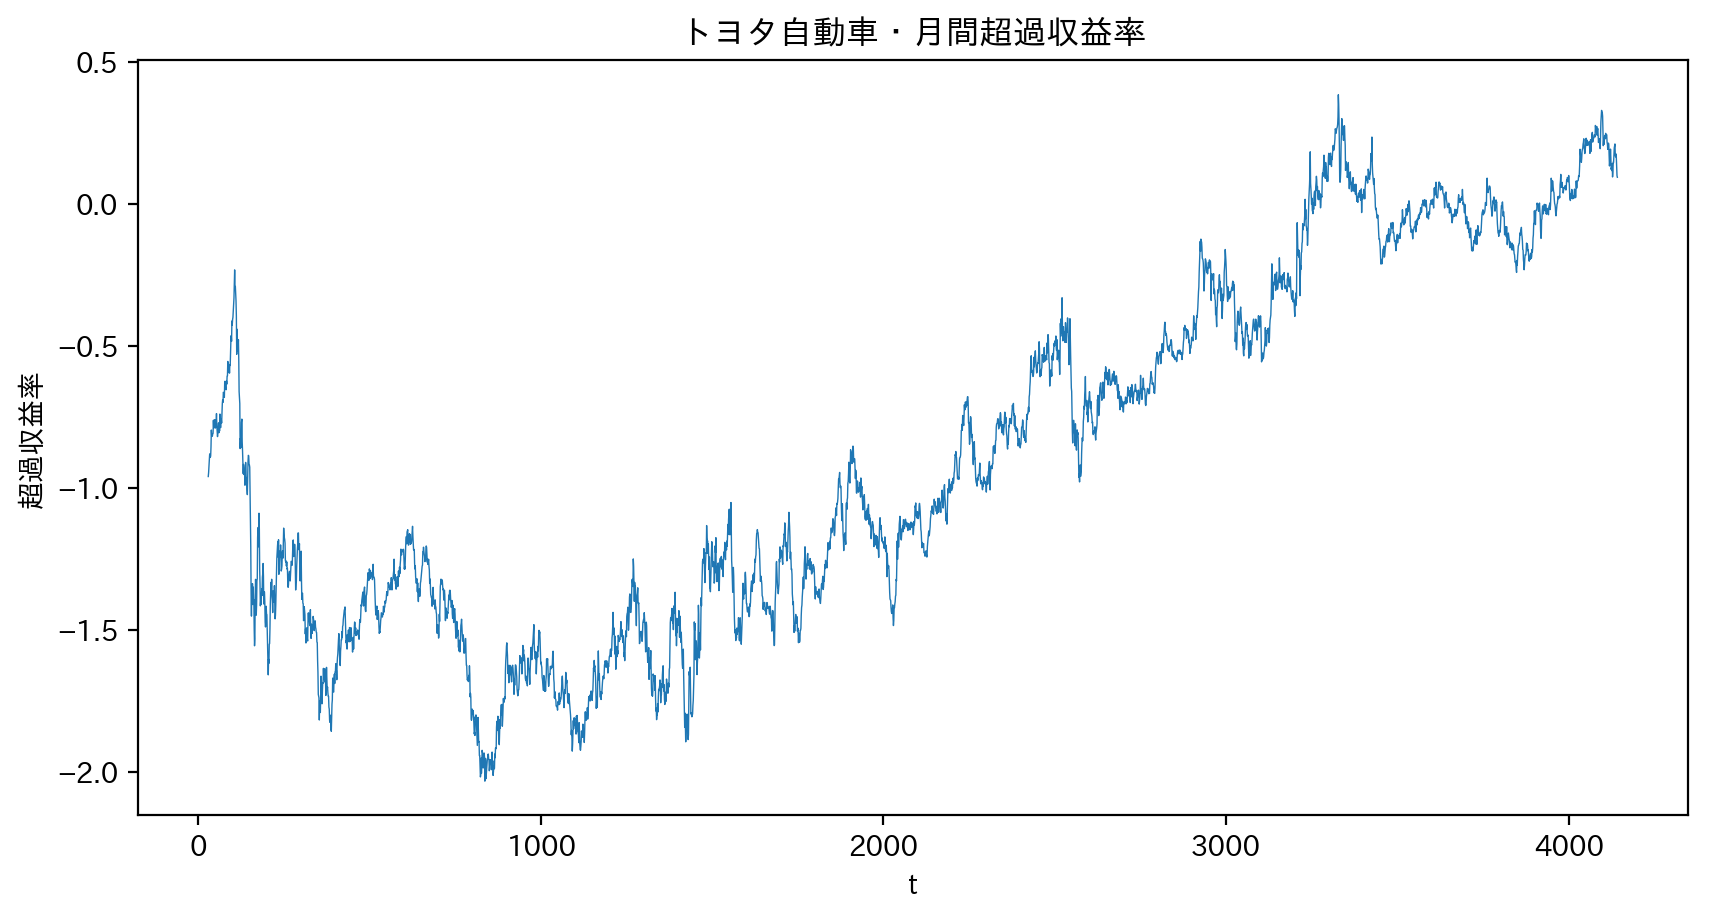

In [63]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"トヨタ自動車・月間超過収益率")
plt.plot(x, linewidth=0.5, label="東京電力")
plt.xlabel('t')
plt.ylabel(r'超過収益率')
plt.savefig("excess_return_series.png")

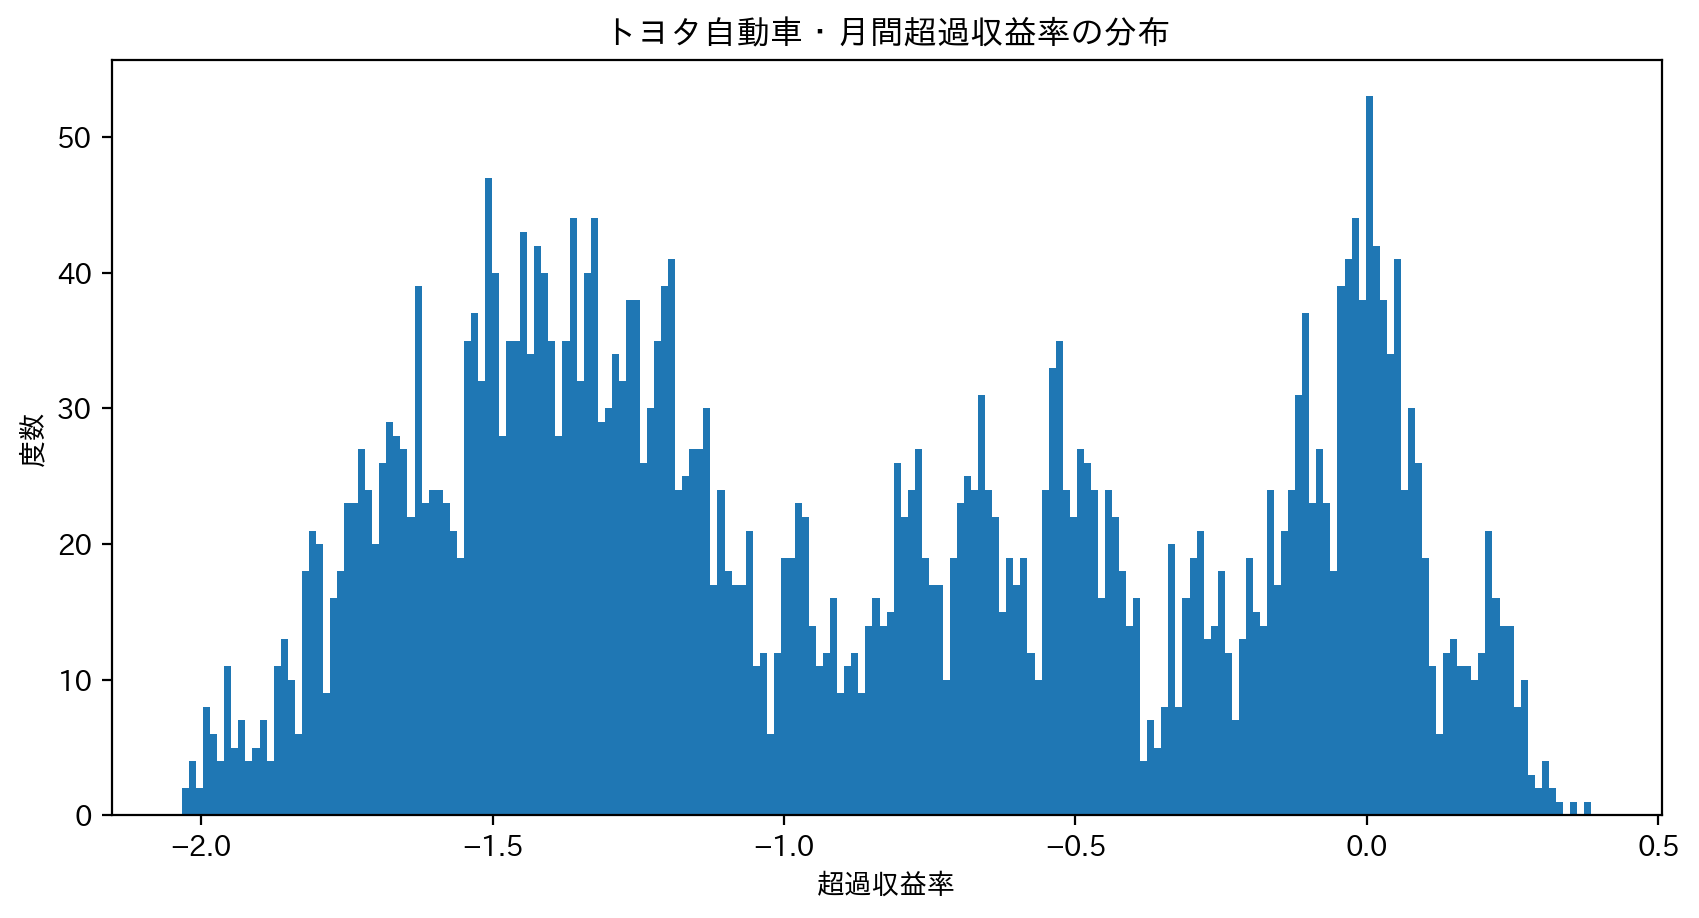

In [64]:
plt.figure(figsize=(10,5),dpi=200)
plt.title(f"トヨタ自動車・月間超過収益率の分布")
plt.hist(x, bins=200)
plt.xlabel('超過収益率')
plt.ylabel(r'度数')
plt.savefig("excess_return_hist.png")

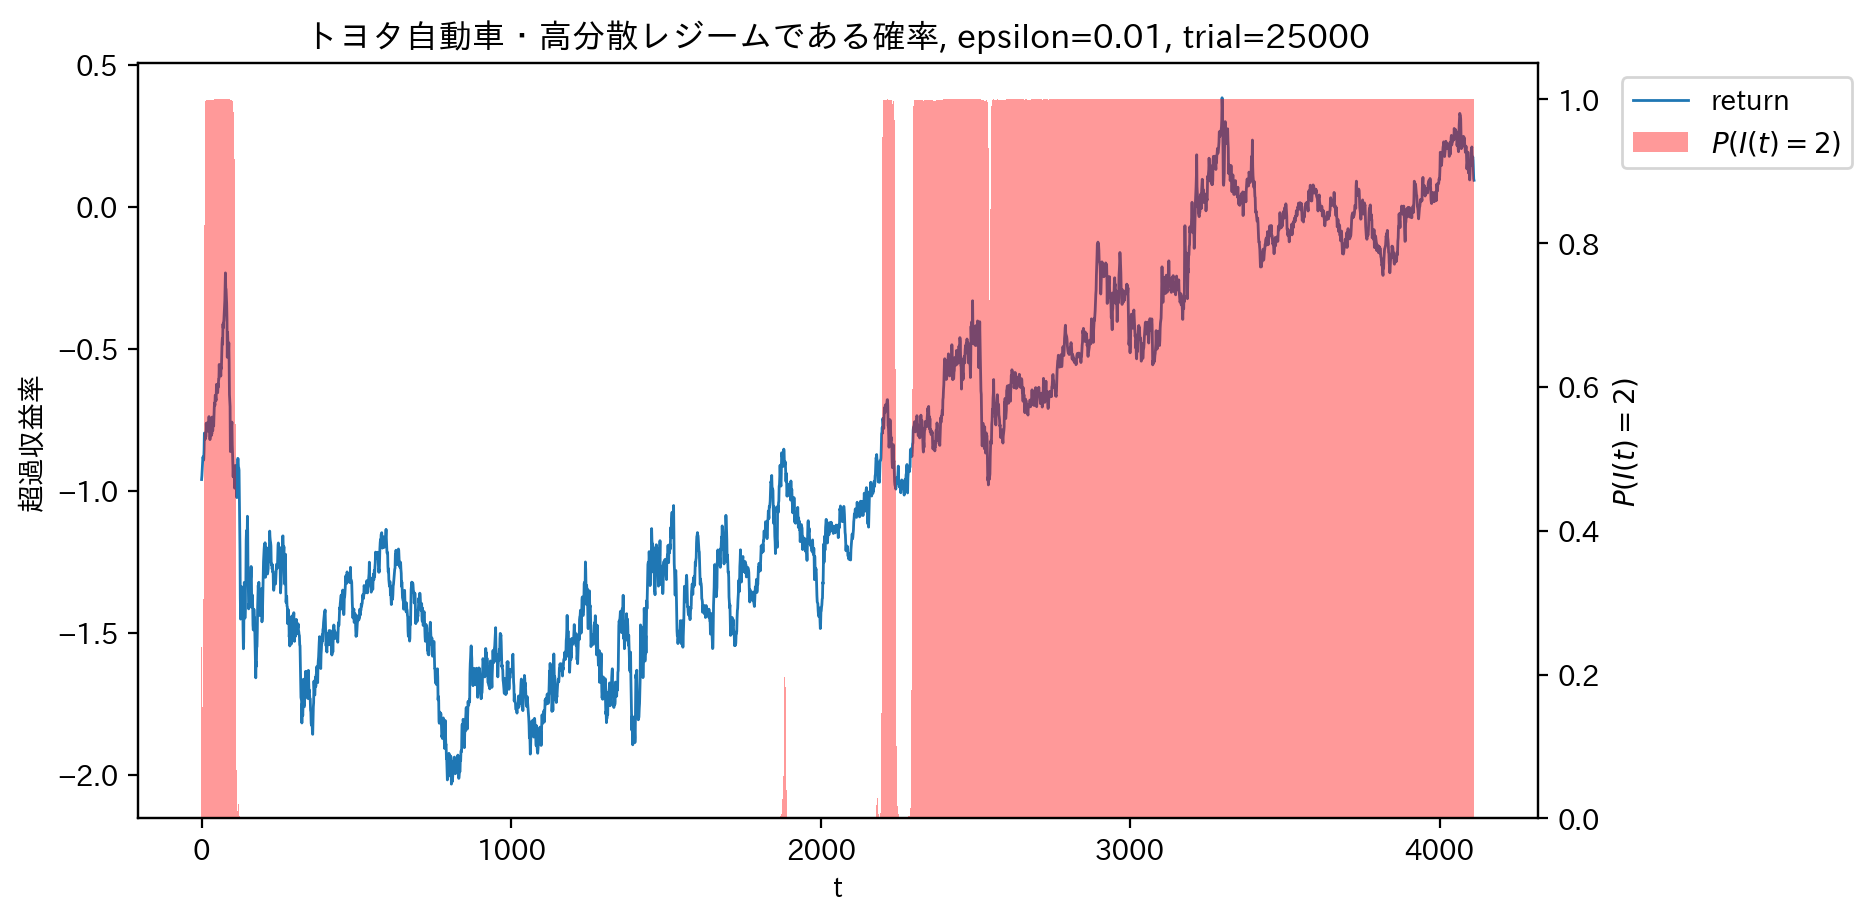

In [65]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ln1=ax1.plot(range(length), x, linewidth = 1.0, label="return")

ax2 = ax1.twinx()
ln2=ax2.bar(range(length), prob2, width=1.0, color="red", alpha=0.4, label=r"$P(I(t) = 2)$")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('t')
ax1.set_ylabel(r'超過収益率')
ax2.set_ylabel(r'$P(I(t) = 2)$')
ax1.set_title(f"トヨタ自動車・高分散レジームである確率, epsilon={epsilon}, trial={trial}")

plt.subplots_adjust(left = 0.1, right = 0.8)
plt.savefig("probability_regime2.png")
plt.show()

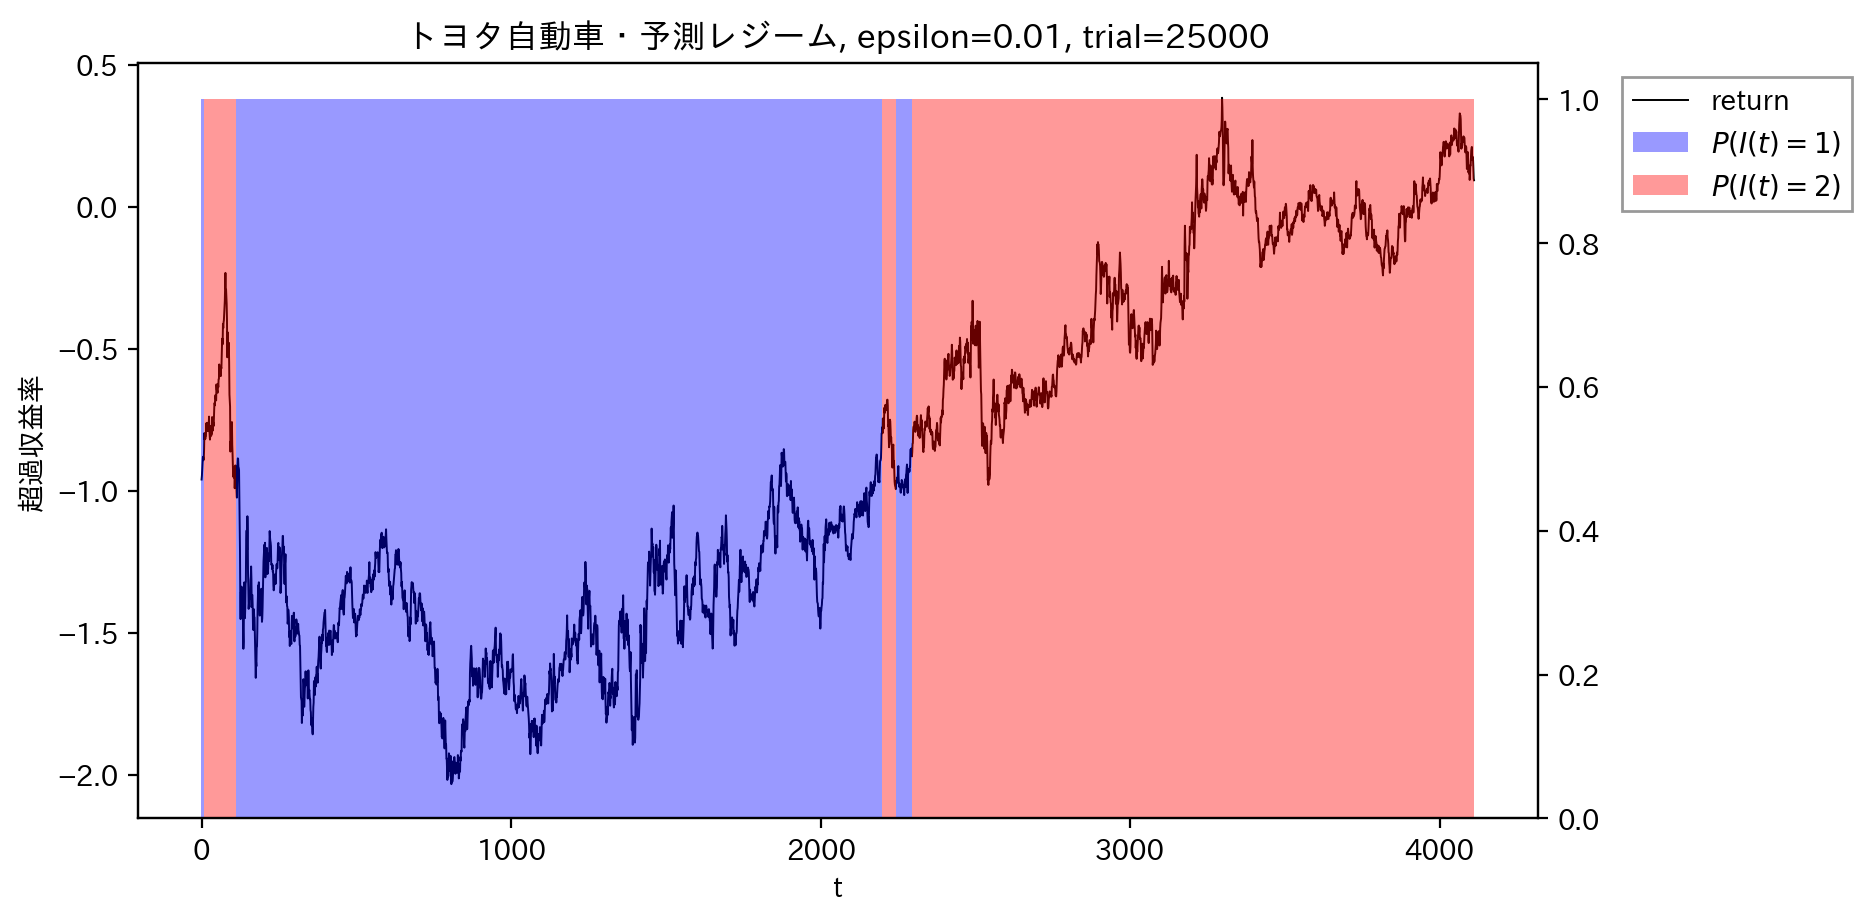

In [66]:
regime = np.array(prob2)>=0.5
regime = regime.astype(int)

fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ln1=ax1.plot(range(length), x, linewidth=0.7, color="black", label="return")

ax2 = ax1.twinx()
ln2=ax2.bar(range(length), 1-np.array(regime), width=1.0, color="blue", alpha=0.4, label=r"$P(I(t) = 1)$")
ln2=ax2.bar(range(length), regime, width=1.0, color="red", alpha=0.4, label=r"$P(I(t) = 2)$")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor="gray", fancybox=False)

ax1.set_xlabel('t')
ax1.set_ylabel(r'超過収益率')
ax1.set_title(f"トヨタ自動車・予測レジーム, epsilon={epsilon}, trial={trial}")

plt.subplots_adjust(left = 0.1, right = 0.8)
plt.savefig("estimated_regime_with_return.png")
plt.show()

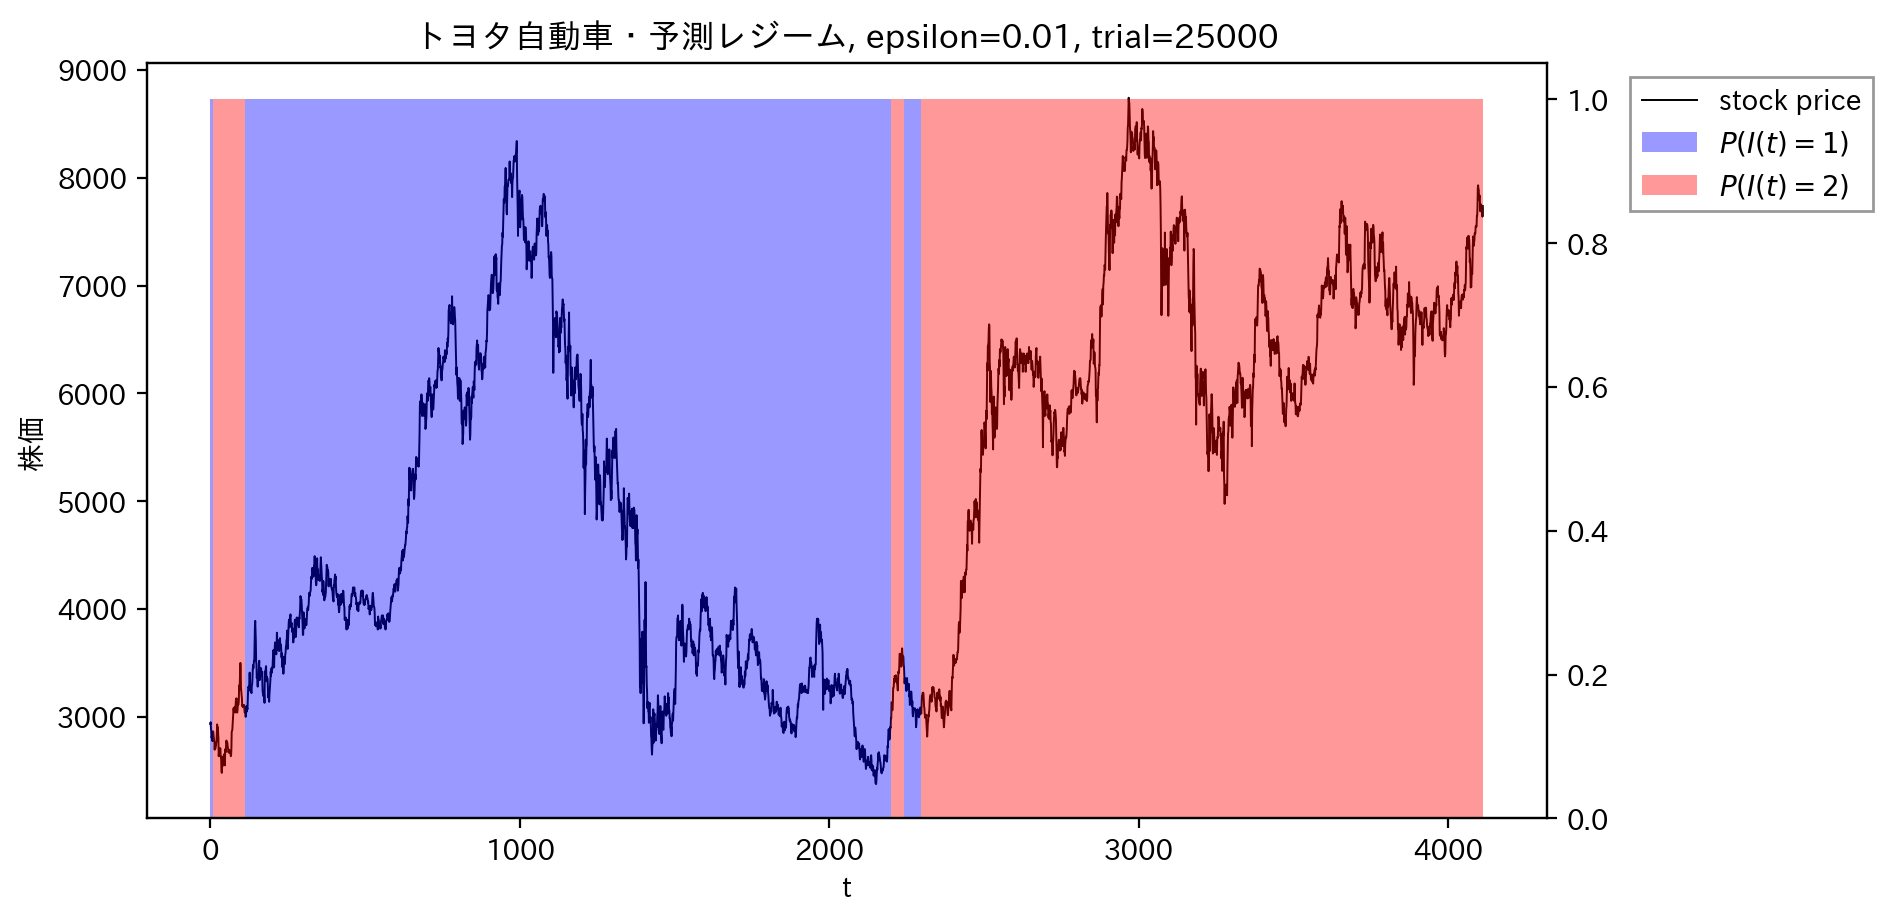

In [67]:
regime = np.array(prob2)>=0.5
regime = regime.astype(int)

fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ln1=ax1.plot(range(length), df["終値調整値"][30:], linewidth=0.7, color="black", label="stock price")

ax2 = ax1.twinx()
ln2=ax2.bar(range(length), 1-np.array(regime), width=1.0, color="blue", alpha=0.4, label=r"$P(I(t) = 1)$")
ln2=ax2.bar(range(length), regime, width=1.0, color="red", alpha=0.4, label=r"$P(I(t) = 2)$")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(1.05, 1), loc='upper left', edgecolor="gray", fancybox=False)

ax1.set_xlabel('t')
ax1.set_ylabel(r'株価')
ax1.set_title(f"トヨタ自動車・予測レジーム, epsilon={epsilon}, trial={trial}")

plt.subplots_adjust(left = 0.1, right = 0.8)
plt.savefig("estimated_regime_with_price.png")
plt.show()

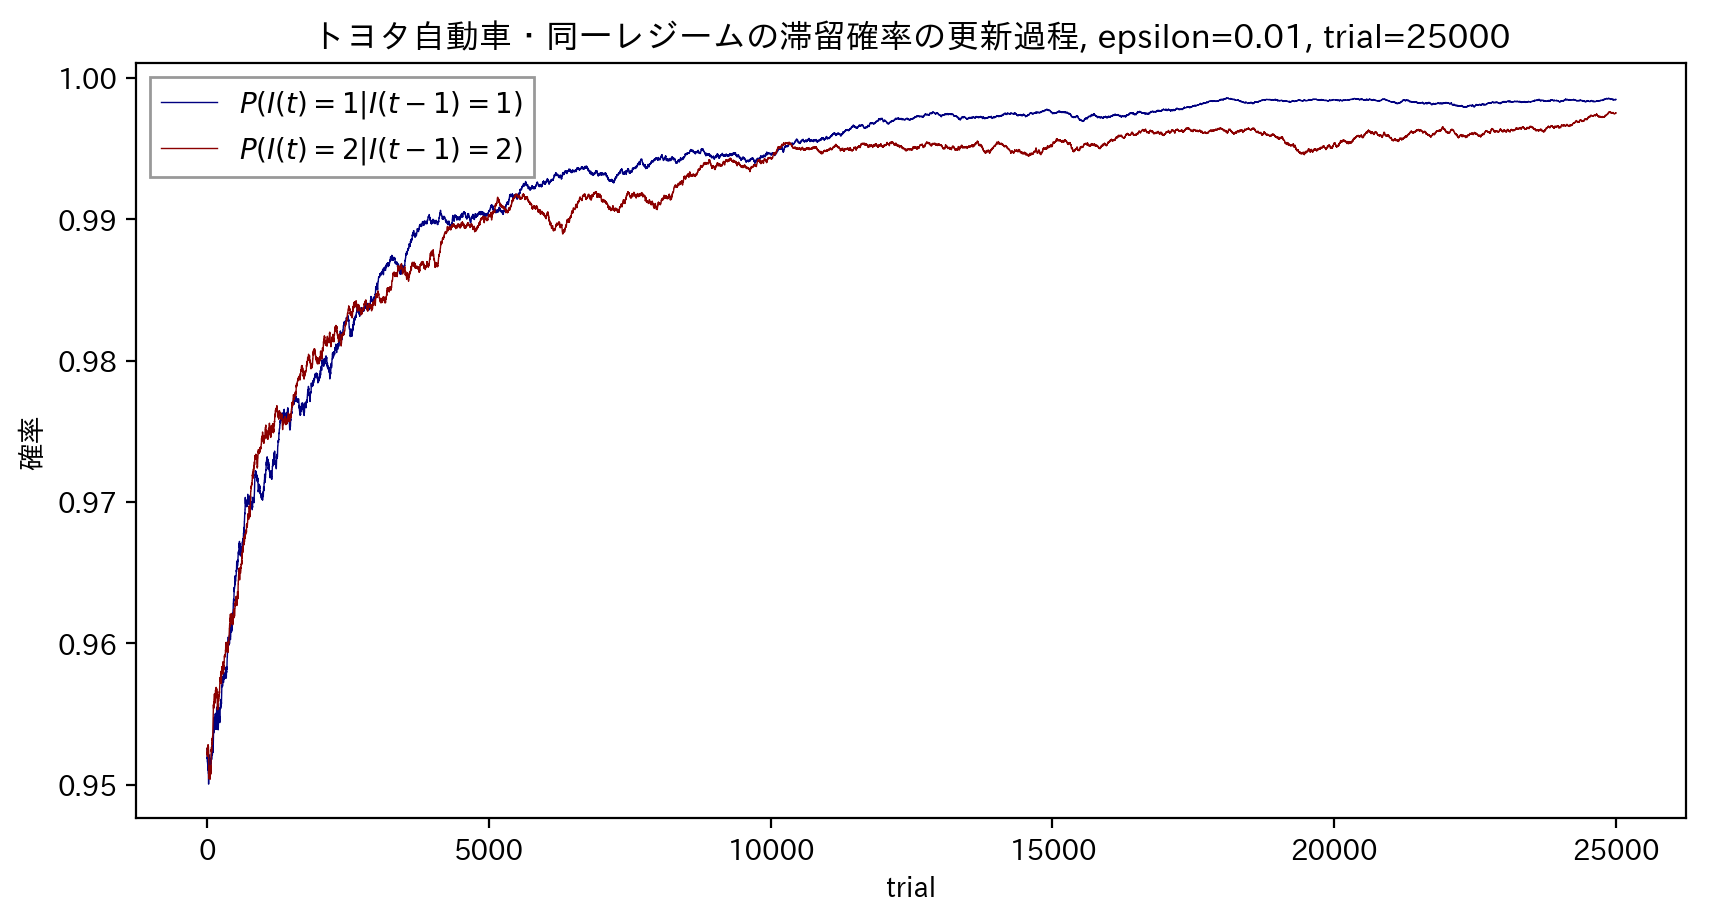

In [68]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax1.plot(theta_list[:,6], linewidth=0.5, color="navy", label=r"$P(I(t) = 1 | I(t-1) = 1)$")
ax1.plot(theta_list[:,7], linewidth=0.5, color="darkred", label=r"$P(I(t) = 2 | I(t-1) = 2)$")
ax1.legend(edgecolor="gray", fancybox=False)
ax1.set_title(f"トヨタ自動車・同一レジームの滞留確率の更新過程, epsilon={epsilon}, trial={trial}")
ax1.set_xlabel('trial')
ax1.set_ylabel(r'確率')

plt.savefig("updating_probability.png")
plt.show()

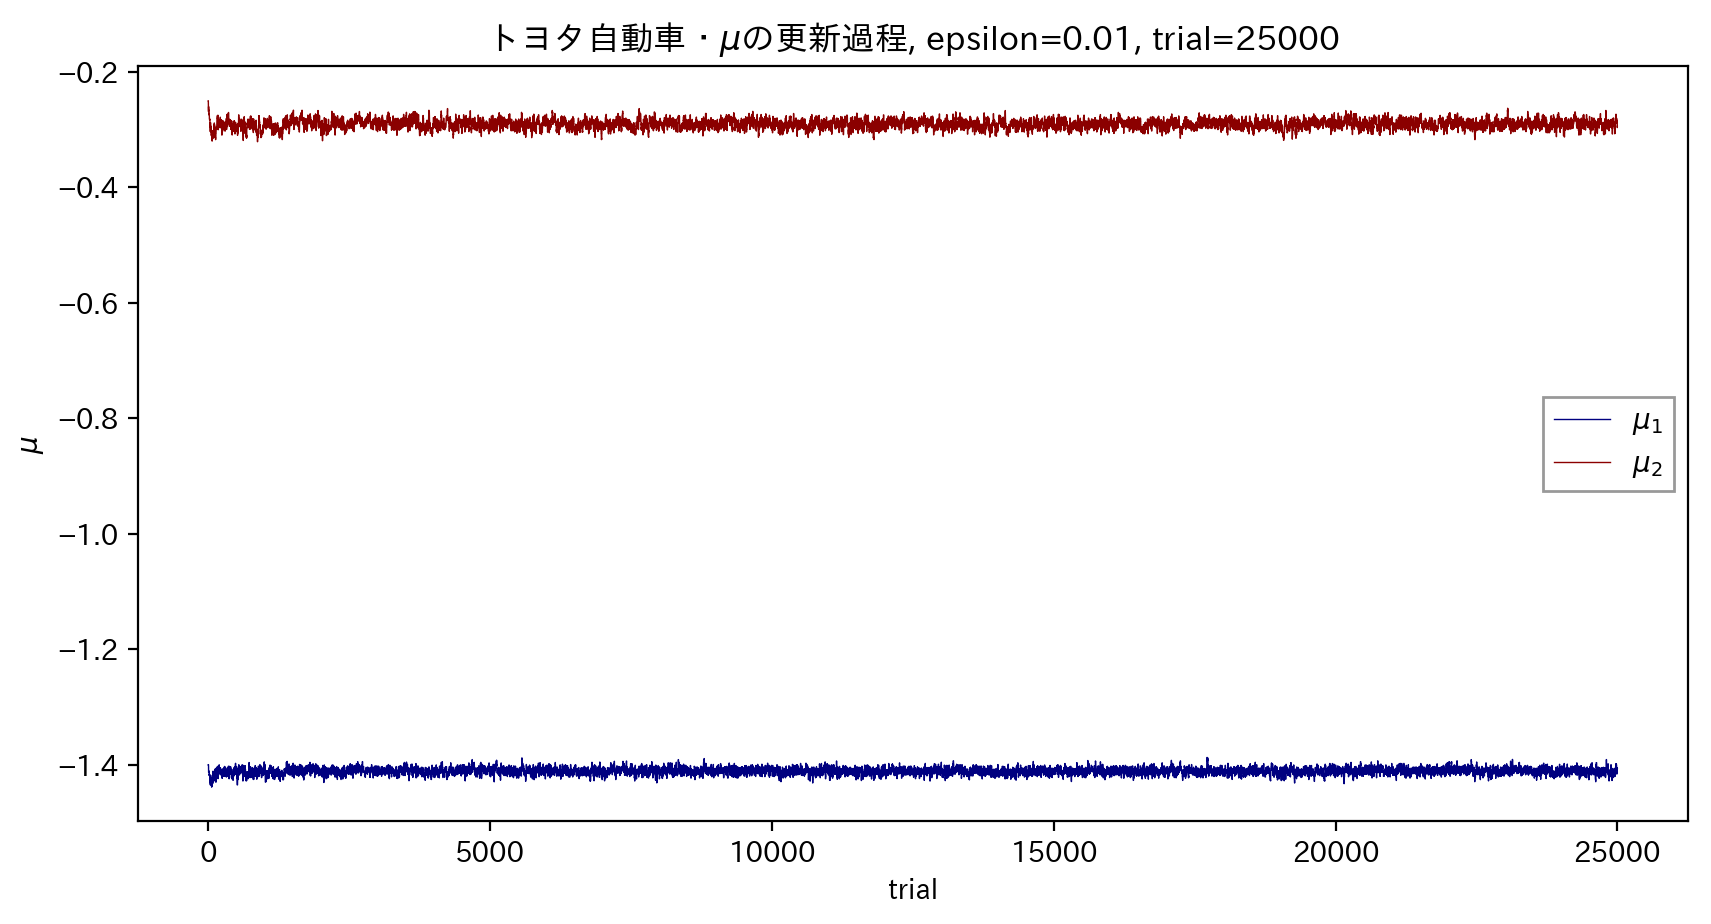

In [69]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax1.plot(theta_list[:,0], linewidth=0.5, color="navy", label=r"$\mu_1$")
ax1.plot(theta_list[:,1], linewidth=0.5, color="darkred", label=r"$\mu_2$")
ax1.legend(edgecolor="gray", fancybox=False)
ax1.set_title(f"トヨタ自動車・$\mu$の更新過程, epsilon={epsilon}, trial={trial}")
ax1.set_xlabel('trial')
ax1.set_ylabel(r'$\mu$')

plt.savefig("updating_mu.png")
plt.show()

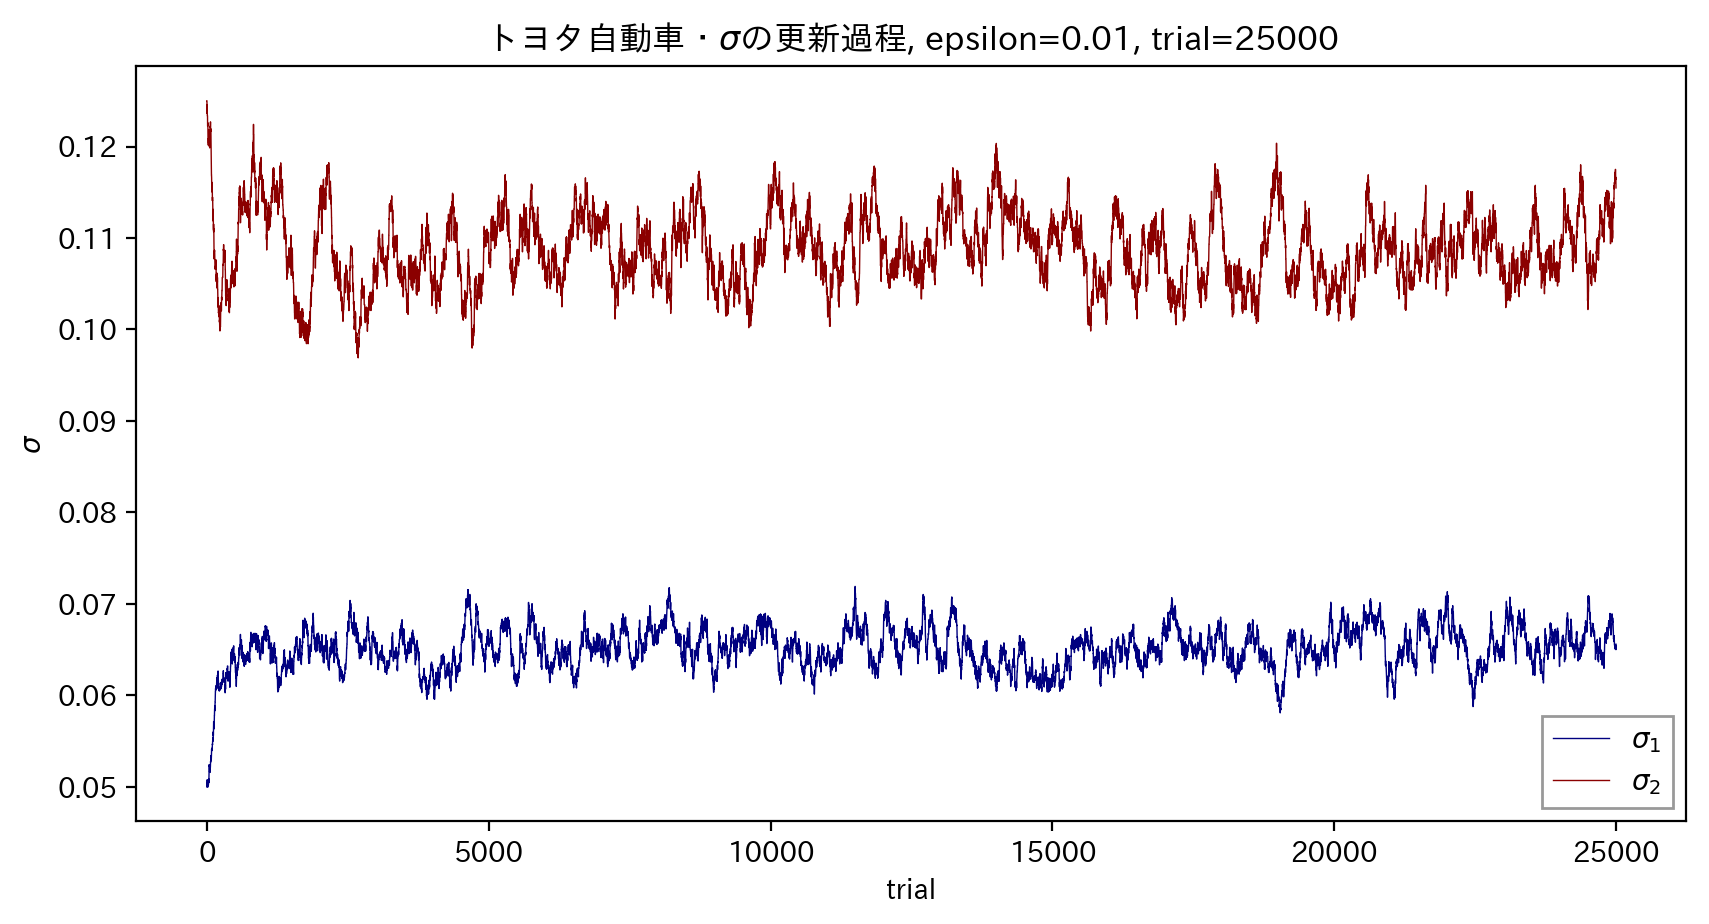

In [70]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax1.plot(theta_list[:,2], linewidth=0.5, color="navy", label=r"$\sigma_1$")
ax1.plot(theta_list[:,3], linewidth=0.5, color="darkred", label=r"$\sigma_2$")
ax1.legend(edgecolor="gray", fancybox=False)
ax1.set_title(f"トヨタ自動車・$\sigma$の更新過程, epsilon={epsilon}, trial={trial}")
ax1.set_xlabel('trial')
ax1.set_ylabel(r'$\sigma$')

plt.savefig("updating_sigma.png")
plt.show()

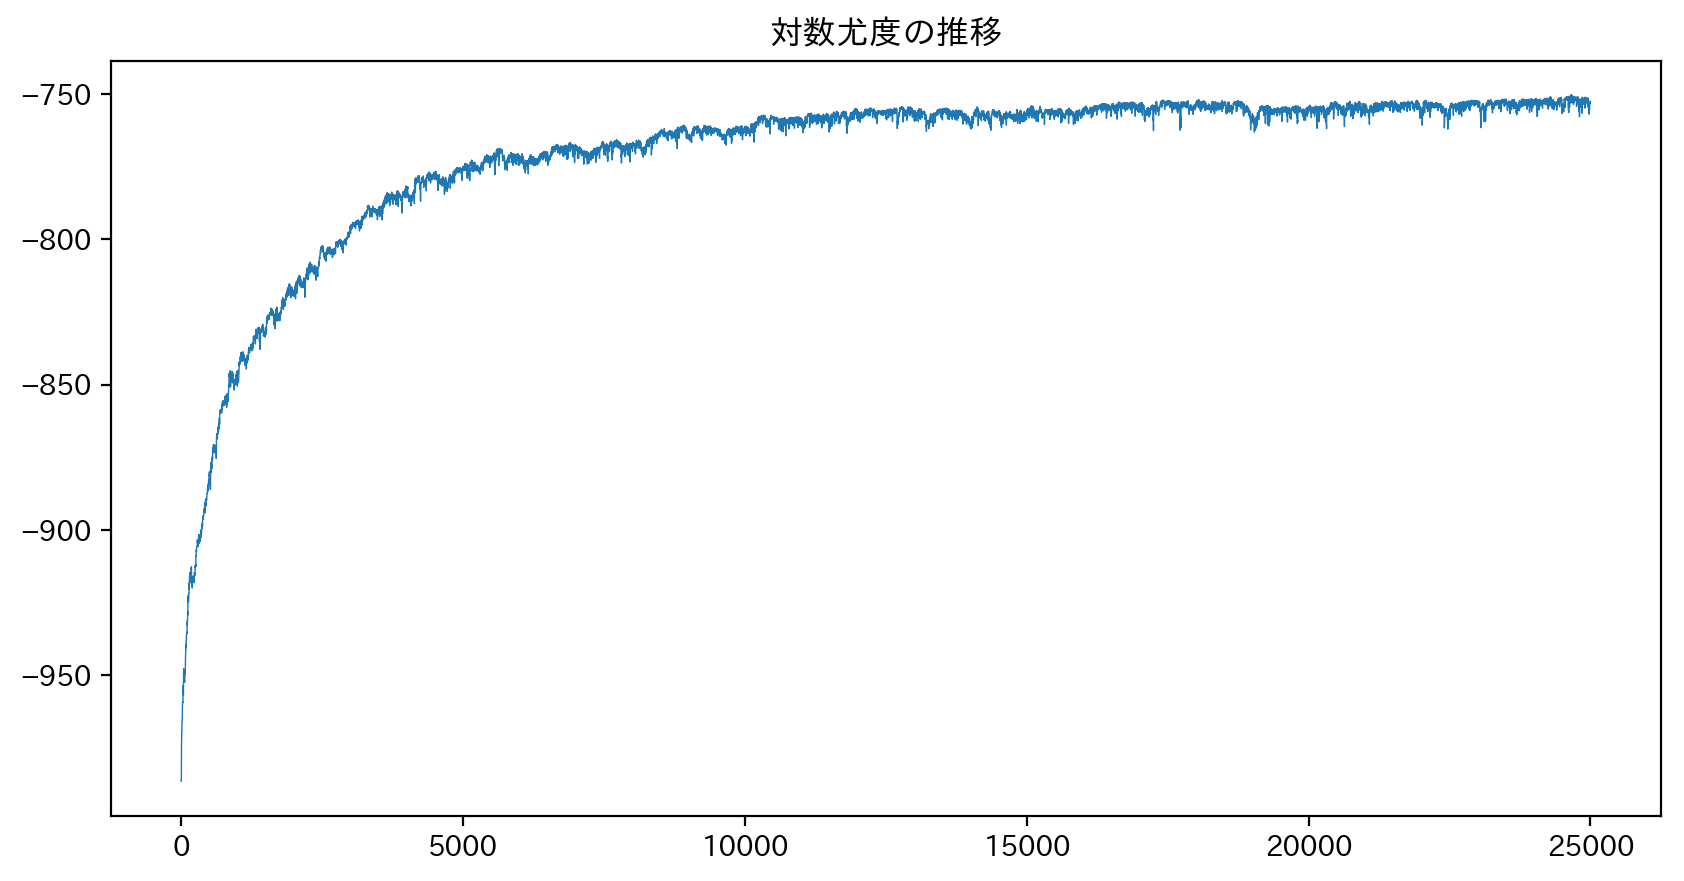

In [71]:
fig = plt.figure(figsize=(10,5),dpi=200)
ax1 = fig.add_subplot(111)
ax1.plot(logL_list, linewidth=0.5)
ax1.set_title(f"対数尤度の推移")
plt.savefig("likelihood.png")
plt.show()